<a href="https://colab.research.google.com/github/bernardobernardob/inC/blob/master/PracticaSpark_BiciMad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

Instalamos y configuramos las herramientas necesarias para empezar a trabajar

In [1]:
!apt-get install openjdk-8-jdk

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

!pip install pyspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded, 10 newly installed, 0 to remove and 43 not upgraded.
Need to get 40.7 MB of archives.
After this operation,

In [0]:
import json
import matplotlib.pyplot as plt
import statistics as stats
from pyspark import SparkContext

In [3]:
!pip install patool

from bs4 import BeautifulSoup
import requests
import zipfile
import patoolib

     |████████████████████████████████| 81kB 3.4MB/s 


In [0]:
sc = SparkContext()

# **Descargamos los datasets de biciMAD**
Automatizamos la obtención de los archivos de datos de la web oficial de biciMAD.

La función **descarga** usa los paquetes Beautiful Soup y request, automatizando la obtención de los archivos. Los renombraremos a '.zip' o '.rar' para poder descomprimirlos y reubicarlos en la carpeta 'datasets'. Por último eliminamos los ficheros comprimidos.

In [0]:
#Estructura de carpetas para el dataset
!mkdir dataset
!cd dataset/
!mkdir dataset/usages
!mkdir dataset/stations

In [0]:
#datos de páginas web para la descarga de los dataset
pagina = "https://opendata.emtmadrid.es"
url = requests.get("https://opendata.emtmadrid.es/Datos-estaticos/Datos-generales-(1)")
html_doc = url.text
soup = BeautifulSoup(html_doc, 'html.parser')
meses_l = [None, "enero","febrero","marzo","abril","mayo","junio","julio",
           "agosto","septiembre","octubre","noviembre","diciembre"]

In [0]:
def descarga(mes,año):
  for link in soup.find_all('a'):
    l = link.get('title')
    if isinstance(l,str):
      if meses_l[mes] in l.lower() and str(año) in l:
        if "uso" in l:
          print(l)
          enlace = link.get('href')
          url = pagina+enlace
          r = requests.get(url, allow_redirects=True)
          open('temp.aspx', 'wb').write(r.content)
          os.rename("temp.aspx","temp.zip")
          try:
            with zipfile.ZipFile("/content/temp.zip", 'r') as zip_ref:
              zip_ref.extractall("/content/dataset/usages")
            os.remove("/content/temp.zip")
          except:
            os.rename("temp.zip","temp.rar")
            patoolib.extract_archive("temp.rar", outdir="/content/dataset/usages")
            os.remove("/content/temp.rar")
        elif "estaciones" in l:
          print(l)
          enlace = link.get('href')
          url = pagina+enlace
          r = requests.get(url, allow_redirects=True)
          open('temp.aspx', 'wb').write(r.content)
          os.rename("temp.aspx","temp.zip")
          try:
            with zipfile.ZipFile("/content/temp.zip", 'r') as zip_ref:
              zip_ref.extractall("/content/dataset/stations")
            os.remove("/content/temp.zip")
          except:
            os.rename("temp.zip","temp.rar")
            patoolib.extract_archive("temp.rar", outdir="/content/dataset/stations")
            os.remove("/content/temp.rar")

In [8]:
for i in range(1,7):
  descarga(i,2019)

Datos de uso de Enero de 2019. Nueva ventana
Situación estaciones bicimad por día y hora de Enero de 2019. Nueva ventana
Datos de uso de Febrero de 2019. Nueva ventana
Situación estaciones bicimad por día y hora de Febrero de 2019. Nueva ventana
patool: Extracting temp.rar ...
patool: running /usr/bin/unrar x -- /content/temp.rar
patool:     with cwd='/content/dataset/stations'
patool: ... temp.rar extracted to `/content/dataset/stations'.
Datos de uso de Marzo de 2019. Nueva ventana
Situación estaciones bicimad por día y hora de Marzo de 2019. Nueva ventana
patool: Extracting temp.rar ...
patool: running /usr/bin/unrar x -- /content/temp.rar
patool:     with cwd='/content/dataset/stations'
patool: ... temp.rar extracted to `/content/dataset/stations'.
Datos de uso de Abril de 2019. Nueva ventana
Situación estaciones bicimad por día y hora de Abril de 2019. Nueva ventana
patool: Extracting temp.rar ...
patool: running /usr/bin/unrar x -- /content/temp.rar
patool:     with cwd='/content

# **Creamos los RDD**
Una vez tenemos las bases de datos descargadas vamos a codificarlas de forma cómoda.

Para tener los datos almacenados de una forma cómoda primero creamos un diccionario cuya clave va a ser un string con el mes y el año del dataset y como valor va a tener el rdd asociado al uso por usuario de ese mes.

La funcion `mapper_usages` nos servirá para crear la rdd más legible. Nos quedaremos con los datos necesarios y cada linea la codificaremos como un diccionario.

In [0]:
rdd_usages = {} 

In [0]:
def mapper_usages(line):
  data = json.loads(line)
  user = data['user_type']
  user_day = data['user_day_code']
  start = data['idunplug_station']
  end = data['idplug_station']
  date = data['unplug_hourTime']['$date'][0:10]
  hora = data['unplug_hourTime']['$date'][11:19]
  time = data['travel_time']
  age = data['ageRange']
  try:
    track = data['track']
  except:
    track = None
  return {"user_type": user,
          "user_day_code": user_day,
          "start": start,
          "end": end,
          "travel_time": time,
          "date": date,
          "hour": hora,
          "age": age,
          "track": track}

In [11]:
directory = 'dataset/usages'
rdd_usages['2019'] = sc.emptyRDD()
for filename in os.listdir(directory):
    if filename.endswith(".json"):
      #Nos quedamos con la fecha del dataset en formato YYYYMM
      name = filename.split("_")[0]
      rdd_usages[name] = sc.textFile(os.path.join(directory, filename)).map(mapper_usages)
      rdd_usages['2019'] = rdd_usages['2019'].union(rdd_usages[name])
      #DEBUG starts
      print(name)
      #DEBUG ends
    else:
        continue

201902
201901
201906
201903
201905
201904


In [12]:
rdd_usages['2019'].take(1)

[{'age': 0,
  'date': '2019-02-01',
  'end': 128,
  'hour': '00:00:00',
  'start': 128,
  'track': None,
  'travel_time': 10,
  'user_day_code': 'd8865be75a4696f3dec4a2e37039fa97582d1efb310c4324e9203d804f4914c0',
  'user_type': 3}]

Por otro lado, un diccionario cuya clave va a ser tambien un string con el mes y el año del dataset y como valor va a tener el rdd asociado a la ocupación de las estaciones en ese mes.

Aquí usaremos la funcion `mapper_stations` para acomodar los datos.

In [0]:
rdd_stations = {}

In [0]:
def mapper_stations(line):
  data = json.loads(line)
  day = data['_id'][0:10]
  hour = data['_id'][11:27]
  station = data['stations']
  return {"day": day, "hour": hour, "station": station}

In [15]:
directory = 'dataset/stations'
rdd_stations['2019'] = sc.emptyRDD()
for filename in os.listdir(directory):
    if filename.endswith(".json"):
      #Nos quedamos con la fecha del dataset en formato YYYYMM
      name = filename.split("_")[2].split(".")[0]
      rdd_stations[name] = sc.textFile(os.path.join(directory, filename)).map(mapper_stations)
      rdd_stations['2019'] = rdd_stations['2019'].union(rdd_stations[name])
      #DEBUG starts
      print(name)
      #DEBUG ends
    else:
        continue

201904
201902
201903
201905
201906
201901


# **Análisis de los meses disponibles de 2019**
En esta primera parte tratamos los 6 primeros meses de 2019, para tener un abanico de datos más amplio del uso de BiciMad.

### **Analisis y comparativas entre datos nocturnos y diurnos.**
De una forma breve, vemos la diferencia entre los datos nocturnos y diurnos, simplemente teniendo en cuenta el número de usuarios.

Lo primero que haremos será ver el número de usuarios diferenciados por tipos según sean horas diurnas o nocturnas.

Tomaremos como 'horas nocturnas' las horas comprendidas entre las 00:00 y las 05:59. Ahora, como en los archivos de bicimad solo se distinguen las horas exactas, nuestras referencias nocturnas serán las 00:00, 01:00, 02:00, 03:00, 04:00 y 05:00.

In [0]:
"""
Con esta funcón, lo que hacemos es quedarnos solo con los datos del rdd, que sean nocturnos.

def horasNocturnas(data):
  #data = json.loads(line)
  #hora_minima = 3600 #Esto seria pasar las 01:00:00 horas a segundos‬
  hora_minima = 0 #Lo pongo en 0 ya que si no estamos perdiendo algun dato relevante para el ultimo problema
  hora_maxima = 18000 #Esto seria pasar las 05:00:00 horas a segundos‬
  hora = data['hour']
  hora_actual = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
  #En teoria con multipicar solo las horas ya valdria porque no hay ni minutos ni segundos
  return hora_actual <= hora_maxima
"""

"\nCon esta funcón, lo que hacemos es quedarnos solo con los datos del rdd, que sean nocturnos.\n\ndef horasNocturnas(data):\n  #data = json.loads(line)\n  #hora_minima = 3600 #Esto seria pasar las 01:00:00 horas a segundos\u202c\n  hora_minima = 0 #Lo pongo en 0 ya que si no estamos perdiendo algun dato relevante para el ultimo problema\n  hora_maxima = 18000 #Esto seria pasar las 05:00:00 horas a segundos\u202c\n  hora = data['hour']\n  hora_actual = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])\n  #En teoria con multipicar solo las horas ya valdria porque no hay ni minutos ni segundos\n  return hora_actual <= hora_maxima\n"

In [0]:
#Con esta función nos quedamos solo con los datos del rdd que sean nocturnos.
def horasNocturnas(data):
  hora_minima = 0
  hora_maxima = 6
  hora_actual = int(data['hour'][:2])
  if hora_minima < hora_maxima:
    return hora_minima <= hora_actual and hora_actual < hora_maxima
  elif hora_minima > hora_maxima:
    return hora_minima <= hora_actual or hora_actual < hora_maxima

In [0]:
"""
Ahora tomamos el rdd que contiene los meses de enero de 2019 a julio de 2019.
"""
rddNocturna = rdd_usages['2019'].filter(lambda x: horasNocturnas(x))

In [0]:
"""
rddNocturna.take(1)
"""

'\nrddNocturna.take(1)\n'

In [0]:
#Separamos ahora por tipo de usuario y vemos cuantos hay de cada tipo en total (para caso nocturno).
night_data = rddNocturna.map(lambda x: x['user_type']).countByValue()
night_data

defaultdict(int, {0: 203, 1: 154927, 2: 1381, 3: 23428})

Creamos una gráfica para ver mejor los datos.

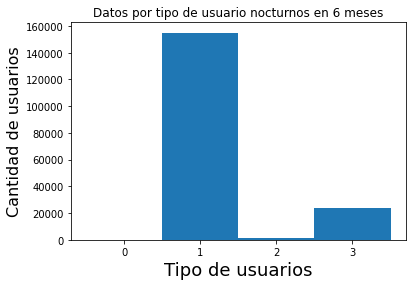

In [0]:
plt.title('Datos por tipo de usuario nocturnos en 6 meses')
names = list(night_data.keys()) 
values = list(night_data.values())
plt.bar(names, values, 1)
plt.xlabel('Tipo de usuarios', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])
plt.show()

Podemos observar como la mayoría de usuarios que han usado bicimad por la noche son usuarios del tipo 1, que son los usuarios anuales mientras que hay muy pocos usuarios ocasionales. 

In [0]:
rddDiurna =  rdd_usages['2019'].filter(lambda x: not(horasNocturnas(x)))

In [0]:
"""
rddDiurna.take(1)
"""

'\nrddDiurna.take(1)\n'

In [0]:
#Separamos ahora por tipo de usuario y vemos cuantos hay de cada tipo en total (para el caso diurno)
day_data = rddDiurna.map(lambda x: x['user_type']).countByValue()
day_data

defaultdict(int, {0: 1646, 1: 1767639, 2: 25599, 3: 118387})

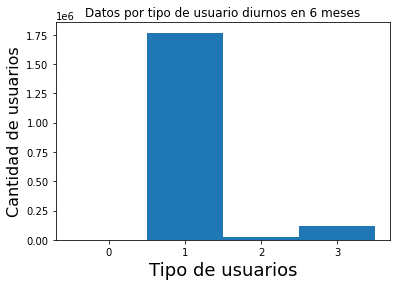

In [0]:
plt.title('Datos por tipo de usuario diurnos en 6 meses')
names = list(day_data.keys()) 
values = list(day_data.values())
plt.bar(names, values, 1)
plt.xlabel('Tipo de usuarios', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
names.sort()
plt.xticks(names, ["0","1","2","3"])
plt.show()

Los datos de los histogramas son muy parecidos por lo que para ver la diferencia entre los datos nocturnos y los diurnos, es necesario hacer una proporcion para ver como son estos datos.

In [0]:
#Proporcion datos nocturnos
print("Proporción 'nocturna' entre tipo 2 sobre tipo 1: ", night_data[2]/night_data[1])

Proporción 'nocturna' entre tipo 2 sobre tipo 1:  0.008913875567202618


In [0]:
#Proporcion datos diurnos
print("Proporción 'diurna' entre tipo 2 sobre tipo 1: ", day_data[2]/day_data[1])

Proporción 'diurna' entre tipo 2 sobre tipo 1:  0.014482029418902842


Ambas proporciones son muy parecidas y bastante bajas por lo que los usuarios ocasionales no repercuten en gran medida en los datos ya que principalmente los usuarios son de tipo anual. Así, aunque en las horas nocturnas podría haber una proporcion mayor de usuarios de tipo 2, no se puede concluir con estos datos

Las proporcion diurna, es un poquito más grande, luego, podemos decir que durante el día hay más usuarios de tipo 2 que durante la noche.

### **Análisis de días laborables y fines de semana**
Cabe pensar que el uso de BiciMad por la noche se acentúa durante los fines de semana, de ahí este apartado.

Creemos que analizar los datos de los fines de semana puede darnos cierta información, dado que a priori, podemos suponer que habrá más movimientos, porque la gente puede estar fuera de casa hasta más tarde.

Lo primero que necesitamos es una función que nos diferencia entre días laborables y fines de semana. Tomaremos como fin de semana viernes, sábado y domingo.

In [0]:
"""
Utilizaremos la librería 'datatime', para obtener de forma sencilla el día de la semana qu es una fecha dada.
"""
from datetime import datetime, date, time, timedelta
import calendar
def cambioFormato(fecha):
  formato1 = "%A" #formatos: https://python-para-impacientes.blogspot.com/2014/02/operaciones-con-fechas-y-horas.html 
                            #https://blog.ipswitch.com/es/formato-de-fecha-en-python 
  dia=datetime.strptime(fecha, '%Y-%m-%d') #El segundo dato es el formato que tiene la fecha que le estoy dando
  dia_1=dia.strftime(formato1)
  return dia_1

In [0]:
def weekend(line, madrugada):
  """
  madrugada es un booleano para decirle si queremos que nos coja los días pero por la noche,
  en plan, en las horas nocturnas, pues queremos que nos coja, los sabados, los domingos y los lunes.
  """
  if madrugada:
    days=['Saturday', 'Sunday', 'Monday']
  else:
    days=['Friday', 'Saturday', 'Sunday'] 
  #por ejemplo si queremos los datos diurnos, pues lo pondríamos a 'not weekend(fecha, FALSE)', para que cogiese estos días
  dia=cambioFormato(line['date'])
  return dia in days

In [0]:
"""
#Esta funcion, dado cualquier dia, te dice si fue fin de semana o no en el año 2019. Tendiendo en cuenta
#que la 'noche' del viernes es sabado ya, por lo que queremos los dias sabado, domingo y lunes.
def is_weekend(data):
  months = [31, 28, 31, 30, 31, 30]#Los dias que tiene cada mes desde enero a junio
  #El 1 de enero de 2019 cayo en Martes
  fin_semana = [4,5,6] #Corrspondiente a los fines de semana.
  fecha_actual = data['date']
  mes_actual = int(fecha_actual[5:7])
  dia_actual = int(fecha_actual[8:10])
  dias_transcurridos = months[mes_actual-1]*(mes_actual-1) + dia_actual
  return dias_transcurridos % 7 in fin_semana
"""

"\n#Esta funcion, dado cualquier dia, te dice si fue fin de semana o no en el año 2019. Tendiendo en cuenta\n#que la 'noche' del viernes es sabado ya, por lo que queremos los dias sabado, domingo y lunes.\ndef is_weekend(data):\n  months = [31, 28, 31, 30, 31, 30]#Los dias que tiene cada mes desde enero a junio\n  #El 1 de enero de 2019 cayo en Martes\n  fin_semana = [4,5,6] #Corrspondiente a los fines de semana.\n  fecha_actual = data['date']\n  mes_actual = int(fecha_actual[5:7])\n  dia_actual = int(fecha_actual[8:10])\n  dias_transcurridos = months[mes_actual-1]*(mes_actual-1) + dia_actual\n  return dias_transcurridos % 7 in fin_semana\n"

In [0]:
rddWeekend=rddNocturna.filter(lambda x: weekend(x, True)) #madrugada a True porque estamos usando datos nocturnos.
weekend_data=rddWeekend.map(lambda x: x['user_type']).countByValue()
weekend_data

defaultdict(int, {0: 162, 1: 88006, 2: 954, 3: 8922})

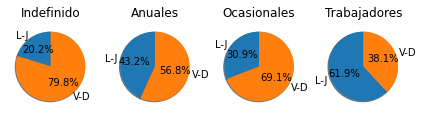

In [0]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,4,1)
plt.pie([night_data[0]-weekend_data[0], weekend_data[0]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Indefinido')
fig.add_subplot(1,4,2)
plt.pie([night_data[1]-weekend_data[1], weekend_data[1]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Anuales')
fig.add_subplot(1,4,3)
plt.pie([night_data[2]-weekend_data[2], weekend_data[2]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Ocasionales')
fig.add_subplot(1,4,4)
plt.pie([night_data[3]-weekend_data[3], weekend_data[3]], labels=['L-J', 'V-D'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Trabajadores')
#plt.legend(['entre semana', 'fin de semana'], loc=4)
plt.show()

Como vemos, más de la mitad de viajeros que tienen pase anual, utilizan BiciMad en el fin de semana. Podemos ver que incluso casi el 70% de los viajes ocasionales se producen durante el fin de semana. Sin embargo, de los trabajadores de la empresa, solo el 38% lo hace en fin de semana.


In [0]:
"""
Esto de aqui abajo es nuevo, al hacerlo me ha parecido interesante y lo he añadido
En verdad yo lo borraria y hablaria de ello en el apartado de las edades que es cuando es
interesante y enlazarlo con esto.
"""

'\nEsto de aqui abajo es nuevo, al hacerlo me ha parecido interesante y lo he añadido\nEn verdad yo lo borraria y hablaria de ello en el apartado de las edades que es cuando es\ninteresante y enlazarlo con esto.\n'

El porcentaje de los usuarios ocasionales es interesante compararlo con el estudio que habíamos realizado antes. En ese caso no se observaba una diferencia notable de este tipo de usuarios entre las horas nocturnas y las diurnas, pero sin embargo, ahora si que hay una clara diferencia teniendo en cuenta tan solo los días en horas nocturnas. Esto se puede deber a que, como sale más gente joven, hagan uso de bicimad para desplazarse. Veamos si es cierto.

In [0]:
nightAges_tipe2 = rddNocturna.filter(lambda x: x['user_type'] == 2).map(lambda x: x['age']).countByValue()
weekendAges_tipe2 = rddWeekend.filter(lambda x: x['user_type'] == 2).map(lambda x: x['age']).countByValue()
print(nightAges_tipe2)
print(weekendAges_tipe2)

defaultdict(<class 'int'>, {0: 1334, 3: 16, 4: 23, 5: 8})
defaultdict(<class 'int'>, {0: 924, 3: 9, 4: 14, 5: 7})


La mayoría de las edades son del tipo 0, que son aquellas que no están identificadas por lo que con estos datos no podemos extraer ninguna información sobre los usuarios de tipo ocasional.

Veamos ahora, los movimientos por horas.


In [0]:
def movimientosPorHoras(data):
  hora= data['hour']
  user=data['user_type']
  age=data['age']
  return hora, (user, age)

Tomamos los movimientos por horas nocturnos:

In [0]:
#rddHoras=rddNocturna.map(movimientosPorHoras)
time_data=rddNocturna.map(movimientosPorHoras).countByKey()
time_data

defaultdict(int,
            {'00:00:00': 59407,
             '01:00:00': 43304,
             '02:00:00': 31143,
             '03:00:00': 19471,
             '04:00:00': 14793,
             '05:00:00': 11821})

Tomamos los movimientos por horas en fin de semana:

In [0]:
#rddHorasWeekend=rddWeekend.map(movimientosPorHoras)
weekend_time_data = rddWeekend.map(movimientosPorHoras).countByKey()
weekend_time_data

defaultdict(int,
            {'00:00:00': 26845,
             '01:00:00': 23227,
             '02:00:00': 18568,
             '03:00:00': 13009,
             '04:00:00': 9402,
             '05:00:00': 6993})

Creamos dos gráficos, uno con los días laborables y otro con los fines de semana.

In [0]:
"""
Para obtener los días laborables, tenemos que 'restar' los datos de los fines de semana a los totales.
"""
laborable_time_data={}
for i in range(0,6):
  laborable_time_data['0'+str(i)+':00:00']=time_data['0'+str(i)+':00:00'] - weekend_time_data['0'+str(i)+':00:00']
laborable_time_data

{'00:00:00': 32562,
 '01:00:00': 20077,
 '02:00:00': 12575,
 '03:00:00': 6462,
 '04:00:00': 5391,
 '05:00:00': 4828}

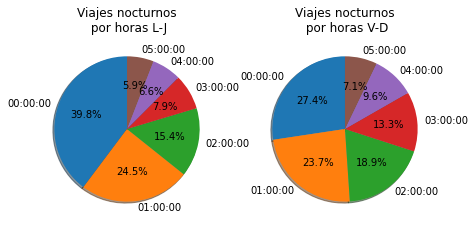

In [0]:
fig=plt.figure()
fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975)
fig.add_subplot(1,2,1)
plt.pie(list(laborable_time_data.values()), labels=list(laborable_time_data.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas L-J')
fig.add_subplot(1,2,2)
plt.pie(list(weekend_time_data.values()), labels=list(weekend_time_data.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Viajes nocturnos\n por horas V-D')
plt.show()

Como vemos, los días laborables, casi el 65% de los viajes, se realizan antes de las 2 de la madrugada y sin embargo, este porcentaje se reduce al 51% cuando hablamos de los fines de semana, donde incrementa el número de viajes a partir de las 2 de la madrugada.

Para entenderlo mejor, veamos también distinciones por horas y usuarios.

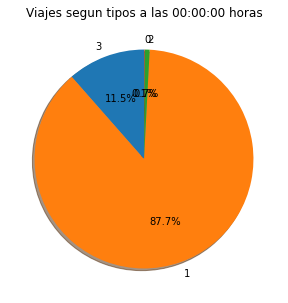

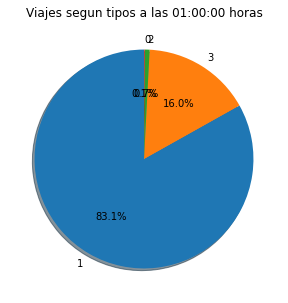

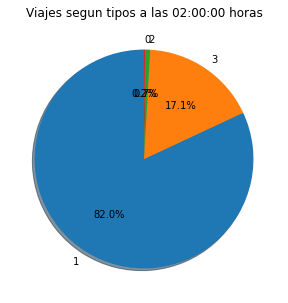

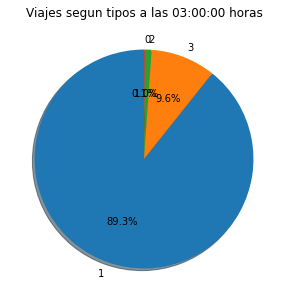

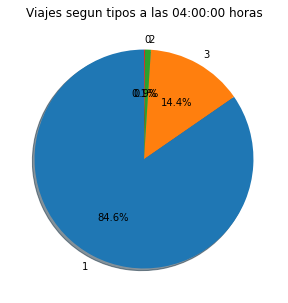

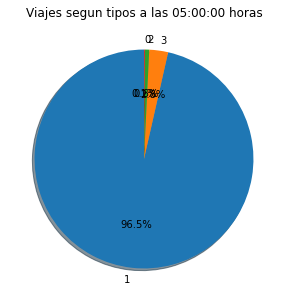

In [0]:
horas = ['00:00:00','01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00']
#fig=plt.figure()
#fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975) 
#fig.add_subplot(3,5,1)
def grafica(dic, value, modo):
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.025, left=0.05, top = 0.975, right=0.975) 
  #linea = value/2 +1
  #pos = (value % 2) + 1
  #fig.add_subplot(linea,5,pos)
  plt.pie(list(dic.values()), labels=list(dic.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
  plt.title('Viajes segun '+modo+' a las '+horas[value]+' horas')
  plt.show()

rddHoras=rddNocturna.map(movimientosPorHoras)
for i in range(len(horas)):
  #grafica(rddHoras.filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1][0], 1)).countByKey(), i)
  grafica(rddHoras.filter(lambda x: x[0] == horas[i]).map(lambda x: (x[1][0], 1)).countByKey(), i, 'tipos')
#Tarda un rato y he intentado ponerlo como lo ponia elisa pero quedaba muy pequeño y no se absolutamente nada. Asi se ve mas pero a lo mejor
#ocupa demasiado.

Como ya habíamos visto, la mayoría de los trayectos que se realizan son por los usuarios de tipo 1, los anuales, pero también hay que tener en cuenta que entre las 1 horas y las 2 horas, hay más de un 15% de los viajes que son realizados por los trabajadores de la empresa. Mientras que a las 12 y a las 3 de la madrugada, no superan el 12%. Oto dato destacable es que a partir de las 5 de la madrugada, casi el 97% de los vaiajes, son hechos por personas que tienen el abono anual.

### **Análisis por rango de edades**

Breve análisis del uso nocturno de BiciMad distinguiendo los usuarios por rangos de edades.

Otro punto interesante, seria estudiar la diferencia en los usos segun los rangos de edad

[(0, 51330), (1, 1320), (2, 695), (3, 7748), (4, 24374), (5, 12343), (6, 234)]


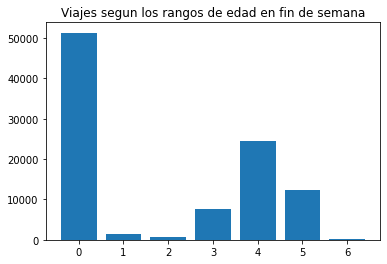

In [0]:
#Empezemos estudiando los usos nocturnos en fines de semana.
"""
Tenemos en cuenta que:
0: no se identifica
1: entre 0 y 16 años
2: entre 17 y 18 años
3: entre 19 y 26 años
4: entre 27 y 40 años
5: entre 41 y 65 años
6: 66 años o más
"""
rddW_ages = rddWeekend.map(lambda x: (x['age'], 1)).countByKey()
print(sorted(rddW_ages.items(), key=lambda x:x[0]))
plt.bar(list(rddW_ages.keys()), list(rddW_ages.values()))
plt.title('Viajes segun los rangos de edad en fin de semana')
plt.show()

A parte de los usuarios no identificados, los que más hacen un uso nocturno los fines de semana son los que están en la franja de edad de entre 27 y 40 años, lo que nos puede indicar que parte de la gente que utiliza bicimad es gente joven. Veamos ahora si este comportamiento es similiar a los dias entre semana.

[(0, 42262), (1, 1837), (2, 489), (3, 5698), (4, 19877), (5, 11616), (6, 116)]


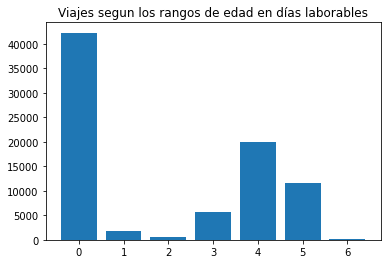

In [0]:
#Partimos de la RDD que tenia los datos filtrados por las horas nocturnas,
#y con poner en filter, que no sea fin de semana, tendremos los días laborables.
rddWD_ages = rddNocturna.filter(lambda x: not weekend(x, True)).map(lambda x: (x['age'])).countByValue()
print(sorted(rddWD_ages.items(), key=lambda x:x[0]))
plt.bar(list(rddWD_ages.keys()), list(rddWD_ages.values()))
plt.title('Viajes segun los rangos de edad en días laborables')
plt.show()

Aunque ambas gráficas son muy parecidas, pero mirando el numero exacto de datos, se observa un claro aumento de los usurios de tipo 3 y 4 en los fines de semana, que son aquellos cuyas edades están entre 19 y 26 años y entre 27 y 40 años respectivamente. Podemos suponer por lo tanto, que los usuarios jóvenes son los que más demanda tienen en horas nocturnas, y por ser más concretos, las personas mayores de edad. Además, hay que tener en cuenta que los datos recogidos los fines de semana se establecen en menos días que los datos de diario por lo que el porcentaje de crecimiento es aun mayor. 

Esto tiene bastante que ver con las gráficas vistas anteriormente en las que se observa claramente como hay un mayor uso los fines de semana.


En estos datos analizados, estamos teniendo en cuenta aquellos que se obtienen por los trabajadores de la empresa y como no nos interesan, veamos si hay algún cambio mayor suprimiendo a los trabajadores.

In [0]:
#eliminamos a los trabajadores de la empresa
rddWD_ages2 = rddNocturna.filter(lambda x: not(weekend(x, True)) and x['user_type'] != 3).map(lambda x: (x['age'])).countByValue()
rddW_ages2 = rddWeekend.filter(lambda x: not(x['user_type'] == 3)).map(lambda x: x['age']).countByValue()
print("Días laborables:", sorted(rddWD_ages2.items(), key=lambda x:x[0]))
print("Fines de semana:", sorted(rddW_ages2.items(), key=lambda x:x[0]))

Días laborables: [(0, 37742), (1, 29), (2, 489), (3, 5698), (4, 15747), (5, 7568), (6, 116)]
Fines de semana: [(0, 48590), (1, 71), (2, 695), (3, 7743), (4, 22304), (5, 9485), (6, 234)]


Los datos son muy parecidos, aunque se observa, como habiamos visto antes un mayor decrecimiento en los datos diarios ya que hay un mayor uso por parte de los trabajdores.

Otra de las cosas que puede ser interesante analizar distinguiendo por rango de edades, son el uso por horas nocturnas. Una vez más tomaremos los datos sin la aportación de los trabajadores y además, quitaremos los datos también de los usuarios con edad de tipo 0 (no se ha podido distinguir su edad) para una visión más clara.

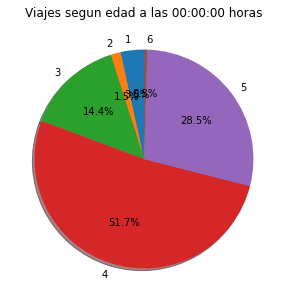

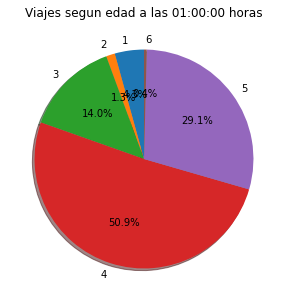

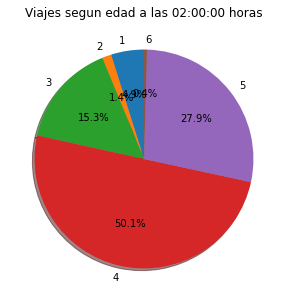

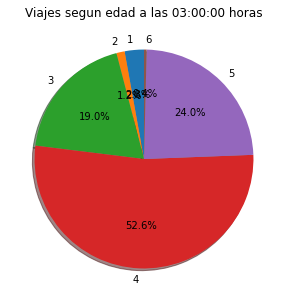

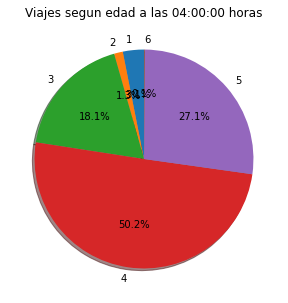

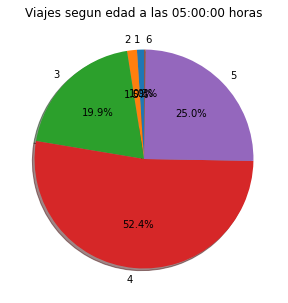

In [0]:
#Los nombres en el gráfico salen 'desordenados' pero bueno, yo creo que da igual.
for i in range(len(horas)):
  grafica(rddHoras.filter(lambda x: x[0] == horas[i]).filter(lambda x: x[1][1] != 0).map(lambda x: (x[1][1], 1)).sortByKey().countByKey(), i, 'edad')

Como podemos ver, no se observa ningún cambio destacable entre las horas. Lo único más notorio, puede ser quizás, que los que están en el rango de edad de tipo 1 (menores de 16 años) empiezan a decrecer un poco a partir de las 3 de la madrugada, lo que por otra parte, es lógico.

In [0]:
"""
#Esta RDD ya tiene los datos importantes usando la funcion mapper        
rddNocturna_ordenada = rddNocturna_datos.map(lambda x: (x[2], 1)).groupByKey().mapValues(tuple).map(lambda x: (len(x[1]), x[0]))
rddNocturna_ordenada.sortByKey(False).map(lambda x: (x[1], x[0])).take(50)
"""

'\n#Esta RDD ya tiene los datos importantes usando la funcion mapper        \nrddNocturna_ordenada = rddNocturna_datos.map(lambda x: (x[2], 1)).groupByKey().mapValues(tuple).map(lambda x: (len(x[1]), x[0]))\nrddNocturna_ordenada.sortByKey(False).map(lambda x: (x[1], x[0])).take(50)\n'

In [0]:
"""
rddNocturna_datos.filter(lambda x: x[2] == 57).map(lambda x: (x[2], x[3])).take(30)
"""

'\nrddNocturna_datos.filter(lambda x: x[2] == 57).map(lambda x: (x[2], x[3])).take(30)\n'

## **Estaciones más y menos usadas**

Esta sección, podríamos incluirla en cada una de las anteriores, por ello, haremos un análisis del uso de las estaciones de forma general, parando en cada uno de los puntos anteriores.

Una de las cosas que sería importante ver para cada uno de los apartados anteriores, son las estaciones más y menos usadas. Por ello, le dedicamos un apartado.

In [0]:
"""
rddNocturna.take(1)
"""

'\nrddNocturna.take(1)\n'

LO HE DEJADO A MEDIAS.

In [0]:
listaEsraciones = rddNocturna_estaciones.sortBy(lambda x: x[1], False).take(10)
listaEsraciones

[(57, 3887),
 (38, 3105),
 (175, 2944),
 (59, 2790),
 (19, 2748),
 (129, 2715),
 (56, 2619),
 (1, 2603),
 (6, 2591),
 (62, 2427)]

In [0]:
#Primero veremos la estación más usada de salida.    
EstMasUsadas = rddNocturna.map(lambda x: (x['start'], 1)).reduceByKey(lambda x,y: x+y)\
               .sortBy(lambda x: x[1], False).take(10)
#rddNocturna_estaciones.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1],x[0])).take(10)#Estoy segura de que hay una forma mucho mejor de hacer esto, pero es que ordenando cosas soy malisima
EstMasUsadas

[(57, 3887),
 (38, 3105),
 (175, 2944),
 (59, 2790),
 (19, 2748),
 (129, 2715),
 (56, 2619),
 (1, 2603),
 (6, 2591),
 (62, 2427)]

In [0]:
rddNocturna_estaciones.map(lambda x: (x[1], x[0])).sortByKey(True).map(lambda x: (x[1],x[0])).take(10)

[(190, 29),
 (183, 30),
 (207, 30),
 (200, 34),
 (213, 46),
 (201, 48),
 (211, 50),
 (119, 67),
 (185, 80),
 (184, 81)]

La estación de la que parten más bicis es la número 57, que se corresponde con la calle/zona de XXXX, y de la que parten menos bicis es la número 29 que se corresponde con la calle/zona de XXXX.
Veamos qué estaciones tienen como destino, los trayectos que parten de esta, para ver si podemos ver alguna relación.

# **Comparativa entre un mes de invierno y un mes de verano**

Como sabemos, cada estación del año modifica ciertos hábitos de las personas, y pensamos que puede ser una de las cosas que afecte al uso nocturno de BiciMad. Para ver las diferencias que se dan, comparamos un mes de invierno y otro de verano.

AQUÍ SE SUPONE QUE VA LO MISMO QUE LO DE LOS 6 MESES PERO PARA CADA MES ENERO Y JULIO. eN TEORÍA SE IRÍA HACIENDO CADA COSA A LA VEZ EN LOS DOS MESESY SE VA COMPARANDO.

# **Análisis de los trabajadores**
Viendo los apartados anteriores, hemos visto, que en algunos casos, puede afectar más o menos el tipo 'trabajador' a los datos por lo que analizaremos los datos ajustados al perfil de trabajador para ver qué información nos aporta.

In [0]:
#rdb es el rdd de los trabajadores
rddTrabajadores = rdd_usages['2019'].filter(lambda x: x['user_type']==3)#.map(lambda x: ((x[1],[x[i] for i in range(2,7)])))

In [0]:
#Debug
rddTrabajadores.take(1)

[{'age': 0,
  'date': '2019-02-01',
  'end': 128,
  'hour': '00:00:00',
  'start': 128,
  'track': None,
  'travel_time': 10,
  'user_day_code': 'd8865be75a4696f3dec4a2e37039fa97582d1efb310c4324e9203d804f4914c0',
  'user_type': 3}]

In [0]:
#rdb por usuarios
num_trabajadores = rddTrabajadores.groupBy(lambda x: x['user_day_code']).mapValues(len).count()#Yo pondría aqui el count
num_trabajadores
#hay 853, diferenciados por día (unos 43 trabajadores fijos??) 
#Para los 6 meses entonces al haber 4968 trabajadores, (unos 42 trabajadores me salen a mi contando que 
#en un mes se trabajan unos 20 dias)

4968

In [0]:
#rdbpu.take(10)

NameError: ignored

<BarContainer object of 31 artists>

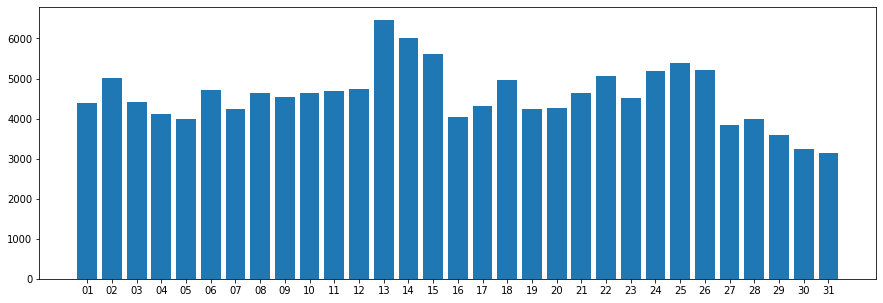

In [0]:
"""
#rdb por días
rdbpd = rdb.map(lambda x: (x[1][3][-3:],1))
rdbpd.take(2)
pd_dicc=rdbpd.countByKey()
pd_list = sorted(pd_dicc.items(), key=lambda x:x[0])
plt.figure(figsize=(15,5))
plt.bar(pd_dicc.keys(), pd_dicc.values())
#no nos da mucha info (quizá ver cuándo son los findes)
"""
#rdb por días
dicT_dias = rddTrabajadores.map(lambda x: (x['date'][-2:],1)).countByKey()
#listT_dias = sorted(dicT_dias.items(), key=lambda x:x[0])
plt.figure(figsize=(15,5))
plt.bar(dicT_dias.keys(), dicT_dias.values())
#no nos da mucha info (quizá ver cuándo son los findes)"""

Esta gráfica no nos proporciona gran información. Con ella en general podemos ver que en todos los días hay una afluencia de trabajo muy similar por lo que no hay días descompensados. Al ser los datos de los 6 primeros meses de 2019, tampoco se puede distinguir si es entre semana o fin de semana ya que no siempre son en el mismo día para meses distintos. 

Veamos ahora si por horas la distribución cambia.

<BarContainer object of 24 artists>

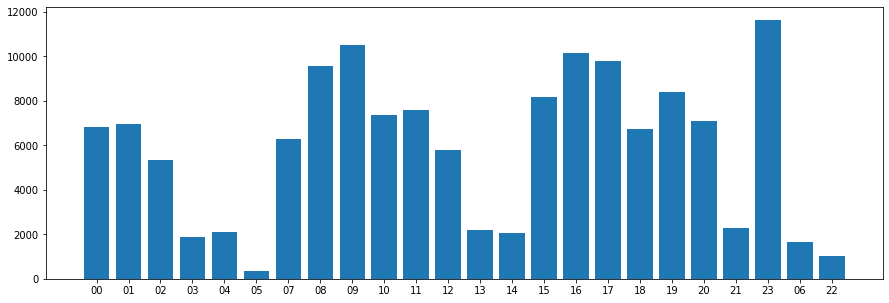

In [0]:
"""
#rdb por horas
rdbph = rdb.map(lambda x: (x[1][4],x[0]))
rdbph.take(2)
ph_dicc=rdbph.countByKey()
ph_list = sorted(ph_dicc.items(), key=lambda x:x[0])
plt.figure(figsize=(15,5))
plt.bar(ph_dicc.keys(), ph_dicc.values())
"""

#rdb por horas
dicT_horas = rddTrabajadores.map(lambda x: (x['hour'][0:2], 1)).countByKey()
plt.figure(figsize=(15,5))
plt.bar(dicT_horas.keys(), dicT_horas.values())

Podemos observar como en las horas nocturnas hay más trabajadores a las 00, la 1 y las 2, que son las horas en las que hay una mayor afluencia de usuarios como hemos observado anteriormente. También hay picos de trabajadores en las primeras horas de la mañana y a partir de las 15 horas, que se corresponden con la entrada y salida diaria del horario laboral. 

In [0]:
def reparacion(data):
  #se trata de una reparación en la misma estación
  user = data['user_type']
  start = data['start']
  end = data['end']
  return user==3 and start==end #Lo de user==3 no haria falta ya que ya esta hecho en la rdd no?
def traslado(data):
  #se trata de una reparación en la misma estación
  user = data['user_type']
  start = data['start']
  end = data['end']
  return user==3 and start!=end
def no_funciona (data):
  #se trata de una reparación en la misma estación
  user = data['user_type']
  start = data['start']
  end = data['end']
  time = data['travel_time']
  return user!=3 and start==end #and time < 121

In [0]:
"""
Esta celda se podría quitar yo creo ya que no hace falta usar el valor repN y asi nos ahorramos una rdd
"""
#nos quedamos con las reparaciones
rddrep = rddTrabajadores.filter(reparacion)
repN = rddrep.count() #hay 5361 veamos cuantas son reparadas de verdad, o solo comprobadas
rddrep.take(1)

[{'age': 0,
  'date': '2019-02-01',
  'end': 128,
  'hour': '00:00:00',
  'start': 128,
  'track': None,
  'travel_time': 10,
  'user_day_code': 'd8865be75a4696f3dec4a2e37039fa97582d1efb310c4324e9203d804f4914c0',
  'user_type': 3}]

Comprobemos ahora que número de bicicletas tienen que ser reparadas y cuales tan solo son comprobadas. Para ello, como filtro usaremos que aquellas comprobaciones que se han necesitado más de 1 minuto serán consideradas como una reparación por parte del trabajador

In [0]:
limite=61
comprobada = rddTrabajadores.filter(lambda x: reparacion(x) and x['travel_time']<limite).count()
reparada = rddTrabajadores.filter(lambda x: reparacion(x) and x['travel_time']>=limite).count()

Proporción de reparaciones rápidas 95.08 %


<BarContainer object of 2 artists>

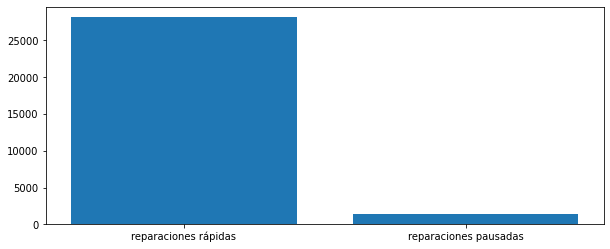

In [0]:
print('Proporción de reparaciones rápidas', "{0:.2f}".format(100*comprobada/(reparada+comprobada)),'%') #proporción del 95% de reparaciones rápidas
plt.figure(figsize=(10,4))
plt.bar(("reparaciones rápidas","reparaciones pausadas"),(comprobada,reparada))

El 95% de las bicis no recibe una reparación pausada por lo que se puede ver como los usuarios hacen un buen uso de bicimad. Así los trabajadores podrán centrarse tan solo en reorganizar las bicicletas para mantener el equilibrio en las estaciones.

In [0]:
#nos quedamos con los traslados
rddTraslado = rddTrabajadores.filter(traslado)
traslados = rddTraslado.count() #16115
rddtras.take(1)

<BarContainer object of 2 artists>

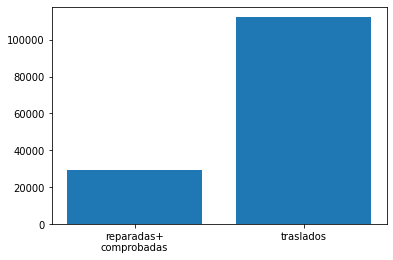

In [0]:
#Veamos ahroa en un gráfico la comparación 
plt.figure(figsize=(6,4))
plt.bar(("reparadas+\ncomprobadas","traslados"),(comprobada+reparada, traslados))

El gráfico nos muestra como la mayoría de movimientos que realizan los trabajadores son traslados de bicicletas entre estaciones, por lo que será interesante analizar más adelante como son estos trayectos 

Veamos ahora si los traslados se realizan a las estaciones más usadas, calculadas en el apartado anterior.
También es interesante comporbar si las estaciones que son menos usadas son de las que se trasladan las bicicletas a aquellas estaciones que tienen una mayor demanda

In [0]:
lisTrasl = rddTraslado.map(lambda x: (x['end'], 1)).reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[1], False).take(10)
"Las estaciones en las que se reponen más bicicletas son:"
lisTrasl

[(162, 3038),
 (91, 2933),
 (154, 2295),
 (108, 2143),
 (109, 2141),
 (139, 1906),
 (102, 1890),
 (83, 1849),
 (167, 1812),
 (129, 1777)]

In [0]:
 EstMasUsadas

In [0]:
rddTraslado.map(lambda x: (x['start'], 1)).reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[1], False).take(10)

[(135, 6402),
 (129, 6190),
 (132, 4750),
 (162, 3603),
 (82, 3597),
 (133, 3424),
 (175, 3359),
 (83, 3283),
 (128, 3107),
 (43, 2850)]

In [0]:
"""
Habria que comentar esto y lo de abajo ya no es mucho de trabajadores creo por lo que no se si habria
ponerlo
"""

'\nHabria que comentar esto y lo de abajo ya no es mucho de trabajadores creo por lo que no se si habria\nponerlo\n'

In [0]:
#nos quedamos con los viajes en que no funciona la bici
rddnof = rdd_usages['2019'].filter(no_funciona)
nofN = rddnof.count() #16115
rddnof.take(1)

[{'age': 0,
  'date': '2019-02-01',
  'end': 131,
  'hour': '00:00:00',
  'start': 131,
  'track': None,
  'travel_time': 985,
  'user_day_code': '38b4e13102db5583f6d465f192cf343ed682a17749886308ae1b189335b06da9',
  'user_type': 1}]

In [0]:
qwe = rddnof.map(lambda x: (x[4],1)).groupByKey().mapValues(len)
qwe.count()

In [0]:
#vamos a ver cuantos de los que cogen la bici por la noche la cogen luego otra vez en ese día
#sin contar trabajadores
rdda = rdd_raw.map(mapper).filter(lambda x: x[0]!=3).map(lambda x: ((x[0],x[1]),tuple(x[2:7])))
rdda.take(2)

In [0]:
a1 = rdda.groupByKey().mapValues(len).filter(lambda x: x[1]==1).count() #cuantos hacen solo un viaje:  89036

In [0]:
a2 = rdda.groupByKey().mapValues(len).filter(lambda x: x[1]!=1).count() #cuantos hacen mas de un viaje: 68954

In [0]:
rddan = rdda.map(lambda x: (x[0],int(x[1][4])))

In [0]:
rddan.take(1)

In [0]:
def to_list(a):
    return [a]

def append(a, b):
    a.append(b)
    return a

def extend(a, b):
    a.extend(b)
    return a

In [0]:
qwe = rddan.combineByKey(to_list, append, extend).map(lambda x: (sorted(x[1]),x[0]))

In [0]:
qwe.take(3)

In [0]:
qwe1 = qwe.filter(lambda x: len(x[0])==1 and min(x[0])<6)
qwe2 = qwe.filter(lambda x: len(x[0])>1 and min(x[0])<6)

In [0]:
qwe1.count() #10698 la usan solo una vez

In [0]:
qwe2.count() #7915 la usan más veces además de en horario nocturno

In [0]:
#ahora vemos de estos las proporciones de usuarios de tipo 1 y 2
qwe11=qwe1.filter(lambda x: x[1][0]==1).count()
qwe12=qwe1.filter(lambda x: x[1][0]==2).count()

In [0]:
qwe21=qwe2.filter(lambda x: x[1][0]==1).count()
qwe22=qwe2.filter(lambda x: x[1][0]==2).count()

# """**PROBLEMA**"""
  """Un usuario desea viajar de una estación a otra en una cierta hora pero no sabe como será la disponibilidad de bicicletas en ese sitio ni si habrá sitio en el lugar de destino, por lo que basando en el historial de ese mismo mes, veremos si el cliente podrá realizar su viaje sin problemas."""

In [0]:
"""
origen = input('Estación de la que se desea partir: ')
destino = input('Estación a la que se desea llegar: ')
hora_Viaje = input('Hora a la que se desea realizar el viaje: ')
"""

"""
Voy a hacer un filtrado simple del fichero de datos de las situaciones de las estaciones para ver como podriamos obtener la informacion que nos interesa dependiendo de la estacion del cliente.
"""

In [0]:
"""
#Hagamos una lista con los datos de todas las estaciones para tenerlos a 
def crearDiEst(lista):
  dicEstac = {}
  for station in lista:
    dicEstac[station['number']] = {}
    dicEstac[station['number']]['id'] = station['id']
    dicEstac[station['number']]['latitude'] = station['latitude']
    dicEstac[station['number']]['longitude'] = station['longitude']
    dicEstac[station['number']]['name'] = station['name']
    dicEstac[station['number']]['total_bases'] = station['total_bases']
  return dicEstac

listEstacion = rdd_stations['201901'].map(lambda x: crearDiEst(x['station'])).take(1)
dicEstaciones = listEstacion[0]
dicEstaciones['57']#Datos de la estacion 57
"""

In [0]:
"""
#Intentemos ver ahora la probabilidad de encontrar bici a la hora que nos dice el cliente.
#De momento establezco yo la hora por comodidad, la estacion de origen y destino tambien
origen = '57'
destino = '38'
horaCliente = '03:00:00'
"""

In [0]:
"""
#De todas las estaciones que hay en todos los datos vamos a quedarnos tan solo con los que son de la estacion que queremos
def estaciones(lista):
  filtro = []
  for estacion in lista['station']:
    if estacion['number'] == origen or estacion['number'] == destino:
      filtro.append(estacion)
  return {"day":lista['day'],
          "hour":lista['hour'],
          "station":filtro}

rddE_Sit_fil = rdd_stations['2019'].map(estaciones)
rddE_Sit_fil.take(3)
"""


In [0]:
"""
#Veamos ahora la probabilidad de que el usuario encuentre una bici disponible en la estacion de partida

def filtPorHora(hora, rango):
    horaViaje = int(horaCliente[0:2]) * 3600 + int(horaCliente[3:5]) * 60 + int(horaCliente[6:8])
    horaDatos = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
    if horaViaje - rango < 0: #Por si la hora que nos dan es menor que la 1
      return horaDatos < horaViaje + rango
    else:
      return horaViaje - rango < horaDatos < horaViaje + rango

def calcularBicisLibres(lista):
  #bicisLibres = []
  for station in lista:
    if station['number'] == origen:
      return station['dock_bikes'] - station['reservations_count'] - station['no_available']

bicisLibres = rddE_Sit_fil.filter(lambda x: filtPorHora(x['hour'], 3600)).map(lambda x: [calcularBicisLibres(x['station'])]).reduce(lambda a, b: a+b)

print('La media de bicicletas libres respecto a la hora elegida es:',int(stats.mean(bicisLibres)))
#La media esta realizada para los datos obtenidos en el rango una hora respecto a la dicha por el cliente

#Por lo tanto la probabilidad de que encuentre una bici disponible es la siguiente
basesTotales = dicEstaciones[origen]['total_bases']
prob = sum(bicisLibres) / (basesTotales * len(bicisLibres))
print('La probabilidad de que haya una bicicleta libre es del', str(100*prob)+'%')
"""

"""Antes de esto que esta hecho, podriamos hacer unas graficas indicando las hora en las que se hacen esos viajes, si son mas comunes en fin de semana o entre semana... (Le podemos dar el toque nocturno y ademas usar todo lo que esta arriba de los graficos que tiene relacion con esto)"""

Primero vamos a hacer un analisis del viaje que quiere realizar el cliente

In [0]:
"""rdd_viaje= rdd_usages['2019'].filter(lambda x: x['start'] == int(origen) and x['end'] == int(destino))
print('Total de viajes similares al del cliente: ', rdd_viaje.count())"""

In [0]:
"""#Veamos cuales son las horas mas comunes para realizar este tipo de viaje.
#fig = plt.figure()
dicc = rdd_viaje.map(lambda x: (int(x['hour'][0:2]), 1)).countByKey()
dicc_list = sorted(dicc.keys())
plt.figure(figsize=(15,5))
plt.title("Usuarios que realizan el viaje "+origen+ " --> "+destino)
plt.bar(dicc.keys(), dicc.values())
plt.xlabel('Horas', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
plt.show()
#plt.xticks(dicc.keys(), dicc_list) No he conseguido que se ponga el numero en todos los contenedores"""

In [0]:
"""#Veamos si hay alguna diferencia en el tipo de usuarios que han realizado el viaje
viaje_usu = rdd_viaje.map(lambda x: (x['user_type'], 1)).countByKey()

print(viaje_usu)
plt.pie(list(viaje_usu.values()), labels=list(viaje_usu.keys()),
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Viaje "+origen+ " --> "+destino+" por tipo de usuario")
plt.show()"""

In [0]:
"""#Veamos la edad de los usuarios que predomina realizando este viaje. 
rdd_viaje.map(lambda x: (x['age'], 1)).countByKey()"""

In [0]:
"""
#Estudiemos ahora las medias en tiempo de todos los viajes, el coste del viaje, etc.
import statistics as stats
listaTiempos = rdd_viaje.map(lambda x: ([x['travel_time']])).reduce(lambda a, b: a + b)
print('La media de tiempo empleado por otros usuarios es: ',stats.mean(listaTiempos), 'segundos')
"""

Esta media de tiempo incluye los viajes a cualquier tipo de hora, pero los que nos interesan son los que se realizan por la noche. Veamos ahora si realizar este trayecto por el día o por la noche afecta en el tiempo medio para recorrer el trayecto. Con este analisis, se verá si afecta el tráfico ya que es el principal causante del incremento en el tiempo de un viaje

In [0]:
#Diferencias de los tiempos medios entre las horas nocturnas y las horas diurnas

tiemposNoc = rdd_viaje.filter(horasNocturnas).map(lambda x: ([x['travel_time']])).reduce(lambda a, b: a + b)
tiemposDiu = rdd_viaje.filter(lambda x: not(horasNocturnas(x))).map(lambda x: ([x['travel_time']])).reduce(lambda a, b: a + b)

In [0]:
mediaNocturna = stats.mean(tiemposNoc)
mediaDiurna = stats.mean(tiemposDiu)
print('Tiempo medio de viajes nocturnos es: ',mediaNocturna, 'segundos')
print('Tiempo medio de viajes diurnos es: ',mediaDiurna, 'segundos')
if mediaNocturna < mediaDiurna:
  print("\nEl tiempo para recorrer el trayecto si se ve afectado por el tráfico, reduciendolo, \nen las horas nocturnas")
else:
  print("El tráfico no afecta a este trayecto")

En caso de no tener claro el trayecto para llegar al destino, le indicaremos al cliente que calles han sido las más transitadas realizando el viaje que se desea hacer.

In [0]:
#Lo uso para ver como son los datos
rdd_viaje.map(lambda x: x['track']).take(5)

In [0]:
#Tan solo estudiaremos los trayectos nocturnos para este caso ya que es lo que nos interesa.

def obtenerCalles(line):
  listaCalles = []
  data = line['track']
  for value in data['features']:
    try:
      calle = value['properties']['var'].split(",")
      listaCalles.append(calle[4])
    except:
      None
  if len(listaCalles) > 0:
    return (listaCalles[-1], listaCalles[0]) #Porque el primer dato es el último que se recibe (de ahí el -1).

rdd_calles = rdd_viaje.filter(horasNocturnas).filter(lambda x: x['user_type'] != 3 and x['track'] != None)\
.map(obtenerCalles).filter(lambda x: x != None)#.collect()#reduce(lambda x, y: [x[0] + y[0], x[1], y[1]])


In [0]:
"""
Veamos por un lado la primera calle más transitada para realizar el viaje y después la última que más
se ha transtidado a la hora de realizar el viaje 
"""
def eliminarNumero(line):
  data = line.split(" ")
  try:
    entero = int(data[-1])
    modulo = len(data[-1])+1
    return line[:-modulo]
  except:
    return line

calleInicial = rdd_calles.map(lambda x: (eliminarNumero(x[0]), 1)).reduceByKey(lambda x, y: x+y)\
                         .sortBy(lambda x: x[1], False).first()

calleFinal = rdd_calles.map(lambda x: (eliminarNumero(x[1]), 1)).reduceByKey(lambda x, y: x+y)\
                       .sortBy(lambda x: x[1], False).first()

print("La primera calle más usada es: ", calleInicial)
print("La última calle más usada es: ", calleFinal)


Hagamos ahora el mismo estudio que al principio y veamos la cantidad de huecos libres que hay en la estación de destino. 

In [0]:
def filtPorHora2(hora, rango):
    horaViaje = int(horaCliente[0:2]) * 3600 + int(horaCliente[3:5]) * 60 + int(horaCliente[6:8]) + mediaNocturna
    horaDatos = int(hora[0:2]) * 3600 + int(hora[3:5]) * 60 + int(hora[6:8])
    if horaViaje - rango < 0:
      return horaDatos < horaViaje + rango
    else:
      return horaViaje - rango < horaDatos < horaViaje + rango

def calcularBasesLibres(lista):
  #bicisLibres = []
  for station in lista:
    if station['number'] == destino:
      return station['free_bases']

basesLibres = rddE_Sit_fil.filter(lambda x: filtPorHora2(x['hour'], 3600)).map(lambda x: [calcularBasesLibres(x['station'])]).reduce(lambda a, b: a+b)

print('La media de bicicletas libres respecto a la hora elegida es:',int(stats.mean(basesLibres)))
#La media esta realizada para los datos obtenidos en el rango una hora respecto a la dicha por el cliente

#Por lo tanto la probabilidad de que encuentre una bici disponible es la siguiente
basesTotales = dicEstaciones[destino]['total_bases']
prob = sum(basesLibres) / (basesTotales * len(basesLibres))
print('La probabilidad de que haya una bicicleta libre es del', str(100*prob)+'%')

# **Asesor de ruta biciMAD**
Aquí, dada una estación de origen, una de destino y una hora del trayecto, calcularemos el tiempo medio necesitado realizar el trayecto, cuántas bicicletas suele haber disponibles en las estaciones, y si suele haber hueco en la estación final para poder colocar la bicicleta.

In [0]:
import statistics as stats

In [0]:
"""
#inputs
origen = input('Estación de la que se desea partir: ') #57
destino = input('Estación a la que se desea llegar: ') #38
hora_Viaje = int(input('Hora a la que se desea realizar el viaje(HH): ')) #17
"""

"\n#inputs\norigen = input('Estación de la que se desea partir: ') #57\ndestino = input('Estación a la que se desea llegar: ') #38\nhora_Viaje = int(input('Hora a la que se desea realizar el viaje(HH): ')) #17\n"

In [0]:
#Intentemos ver ahora la probabilidad de encontrar bici a la hora que nos dice el cliente.
#De momento establezco yo la hora por comodidad, la estacion de origen y destino tambien
origen = '57' #string
destino = '38' #string
hora_Viaje = int('03') #int

In [0]:
#Función que se queda con los viajes alrededor de la hora solicitada
def rangoTiempo(hora, rango, hora_target):
    hora = hora.split(":")
    h = int(hora[0])
    m = int(hora[1])
    hora = h + m/60.0
    #print(hora)
    if (hora_target - rango < 0):
      return((hora < hora_target + rango) or 24 + hora_target - rango < hora)
    else:
      return(hora_target - rango < hora and hora < hora_target + rango)

#rangoTiempo('03:00:00', 1, 3.5)

3.0


True

In [0]:
#Aquí hacemos un primer filtro quedándonos con todos los trayectos que parten de 
#la estación origen y terminan en la estacion destino
rdd_trayecto = rdd_usages['2019'].filter(lambda x: x['start'] == int(origen) and x['end'] == int(destino))

In [0]:
#Debug
print('Total de viajes similares al del cliente sin tener en cuenta el horario: ', rdd_trayecto.count())

Total de viajes similares al del cliente sin tener en cuenta el horario:  690


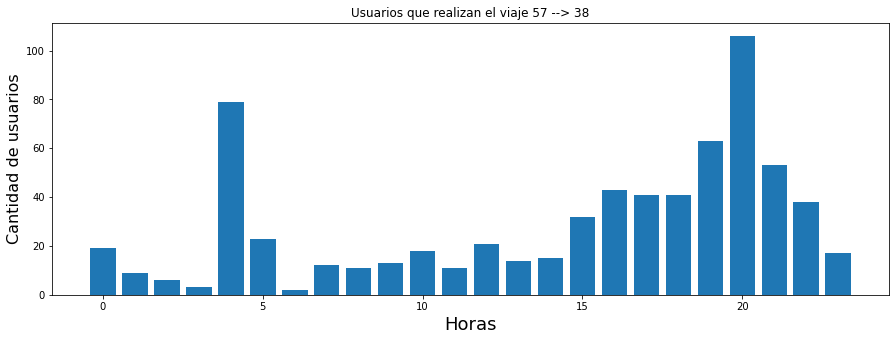

In [0]:
#Veamos cuales son las horas más comunes para realizar este tipo de viaje.
#fig = plt.figure()
dicc = rdd_trayecto.map(lambda x: (int(x['hour'][0:2]), 1)).countByKey()
dicc_list = sorted(dicc.keys())
plt.figure(figsize=(15,5))
plt.title("Usuarios que realizan el viaje "+origen+ " --> "+destino)
plt.bar(dicc.keys(), dicc.values())
plt.xlabel('Horas', fontsize=18)
plt.ylabel('Cantidad de usuarios', fontsize=16)
plt.show()
#plt.xticks(dicc.keys(), dicc_list) No he conseguido que se ponga el numero en todos los contenedores

In [0]:
#Y ahora filtramos ya solo en el rango de horas especificado. 
#En este caso 1 hora alrededor de la hora elegida
rdd_viaje = rdd_trayecto.filter(lambda x: rangoTiempo(x['hour'], 1.01, hora_Viaje))

In [0]:
print('Total de viajes similares al del cliente alrededor de la hora especificada: ', rdd_viaje.count())

Total de viajes similares al del cliente alrededor de la hora especificada:  88


In [0]:
def prititime(segundos):
  m = int(segundos // 60)
  s = int(segundos % 60)
  return "{0} minutos y {1} segundos".format(m,s)

#Estudiemos ahora las medias en tiempo de todos los viajes similares a esa hora
listaTiempos = rdd_viaje.map(lambda x: ([x['travel_time']])).reduce(lambda a, b: a + b)
media_tiempo_viaje = stats.mean(listaTiempos)
print('La media de tiempo empleado por otros usuarios es',prititime(media_tiempo_viaje))

La media de tiempo empleado por otros usuarios es 6 minutos y 37 segundos


In [0]:
def estaciones(lista):
  filtro = []
  for estacion in lista['station']:
    if estacion['number'] == origen or estacion['number'] == destino:
      filtro.append(estacion)
  return {"day":lista['day'],
          "hour":lista['hour'],
          "station":filtro}

"""
rdd_stations['201901a06'] = rdd_stations['201901'].union(rdd_stations['201902'].union(rdd_stations['201903'].union(rdd_stations['201904'].union(rdd_stations['201905'].union(rdd_stations['201906'])))))
"""

#rdd_Sit_fil contiene solo los datos de las dos estaciones,
#la de partida y la de llegada
rdd_Sit_fil = rdd_stations['2019'].map(estaciones)

In [0]:
#Debug
rdd_Sit_fil.take(3)

In [0]:
def calcularBasesLibres(lista, n_estacion):
  for station in lista:
    if station['number'] == n_estacion:
      return station['free_bases']

def calcularBicisLibres(lista, n_estacion):
  for station in lista:
    if station['number'] == n_estacion:
      return station['dock_bikes'] - station['reservations_count'] - station['no_available']

bicisLibres = rdd_Sit_fil.filter(lambda x: rangoTiempo(x['hour'], 1.5, hora_Viaje))\
              .map(lambda x: [calcularBicisLibres(x['station'], origen)]).reduce(lambda a, b: a+b)
basesLibres = rdd_Sit_fil.filter(lambda x: rangoTiempo(x['hour'], 1.5, media_tiempo_viaje / 3600.0))\
              .map(lambda x: [calcularBasesLibres(x['station'], destino)]).reduce(lambda a, b: a+b)

In [0]:
totalBasesPorEstacion = {}
stationsLst = rdd_Sit_fil.take(1)[0]['station']
totalBasesPorEstacion[stationsLst[0]['number']] = stationsLst[0]['total_bases']
totalBasesPorEstacion[stationsLst[1]['number']] = stationsLst[1]['total_bases']

print('La media de bicicletas libres en', origen, 'respecto a la hora elegida es:',int(stats.mean(bicisLibres)), '/', totalBasesPorEstacion[origen])
print('La media de bases libres en', destino ,'respecto a la hora estimada de llegada es:',int(stats.mean(basesLibres)), '/', totalBasesPorEstacion[destino])

La media de bicicletas libres en 57 respecto a la hora elegida es: 8 / 24
La media de bases libres en 38 respecto a la hora estimada de llegada es: 4 / 24


# **Ciclos**
Vemos la parte de los triciclos y demás.

In [0]:
#rddprima da el formato (('usuario','tipo'),[lista de [partida,llegada]])
rddprima = rdd_usages['2019'].map(lambda x: ((x['user_day_code'],x['user_type']),[x['start'],x['end']]))\
                              .groupByKey().map(lambda x: (x[0],list(x[1])))

In [0]:
#adic pasa la lista de pares [partida,llegada] en un diccionario con
#claves las estaciones de partida y valores la lista de estaciones de llegada
def adic(ldl):
  d = {}
  for elem in ldl:
    key,value = str(elem[0]),str(elem[1])
    if key in d:
      d[key].append(value)
    else:
      d[key]=[value]
  return d

In [0]:
separador = "_"
#unomas actualiza el diccionario con un trayecto entre estaciones
#comprobando si ese paso resulta en un ciclo o no
def unomas(dic):
  dic2 = {}
  dk = list(dic.keys())
  for key in dk:
    if not isinstance(key, tuple): #todavía no es un ciclo
      for elem in dic[key]:    
        if key==elem:
          dic2[tuple(set([key]))]=1 #[integer] indica ciclo longitud 1
        else:
          spl = key.split(separador)
          if elem in spl:
            pos = spl.index(elem)
            lis = spl[pos:]
            dic2[tuple(set(lis))] = len(spl)-pos #[integer] indica ciclo
          else:
            try:
              dic2[key+separador+elem]=dic[elem]
            except KeyError:
              pass
  dic2.update(dic)
  return dic2

In [0]:
#sigue llama recursivamente a unomas para recorrer el grafo del usuario
#en profundidad hasta que se obtiene todos los trayectos posibles
def sigue(dic):
  if len(dic) == len(unomas(dic)):
    return dic
  else:
    return (sigue(unomas(dic)))

In [327]:
#ejemplos para entender la función sigue (recursivamente unomas)
ejemplo = [[1,2], [2,1],[2,3],[3,4],[4,2],[4,4],[4,5],[5,6], [6,1]]
ejemploadic = adic(ejemplo)
ejemplociclos = sigue(ejemploadic) # los ciclos son los que tienen como clave una tupla
for key in ejemplociclos.keys():
  if isinstance(key,tuple):
    print(key,"es ciclo de longitud",ejemplociclos[key])

('2', '5', '6', '1', '4', '3') es ciclo de longitud 6
('2', '1') es ciclo de longitud 2
('2', '4', '3') es ciclo de longitud 3
('4',) es ciclo de longitud 1


In [0]:
#tiene ciclos es un filtro booleano que indica si el usuario
#ha realizado algún ciclo en ese día
def tieneciclos(dic):
  resultado = False
  for key,value in dic.items():
    if isinstance(key,tuple):
      resultado = True
  return resultado

In [0]:
#dameciclos se queda con las entradas del diccionario que señalan
#los ciclos, con clave ahora la longitud
def dameciclos(dic):
  dic2 = {}
  for key,value in dic.items():
    if isinstance(key,tuple):
      try:
        dic2[value].append(key)
      except:
        dic2[value]=[key]
  return dic2

In [0]:
#elimina los ciclos duplicados: al tratar las rdds a veces no consigue
#obtener la misma tupla del ciclo como clave, igual sale desordenada
#y considera que es otro ciclo distinto, teniendo la misma longitud y las mismas
#estaciones, por eso aquí eliminamos los duplicados
def eliminadup(dic):
  daux = {}
  for key,val in dic.items():
    for elem in val:
      try:
        if set(elem) in daux[key]:
          pass
        else:
          daux[key].append(set(elem))
      except:
        daux[key]=[set(elem)]
  dic2 = {}
  for key in daux.keys():
    dic2[key]=[]
    for val in daux[key]:
      dic2[key].append(tuple(val))
  return dic2

In [0]:
#rdd_ciclos tiene para cada usuario, los ciclos que ha hecho en un diccionario
#cuyasclaves son las longitudes de los ciclos
rdd_ciclos = rddprima.mapValues(lambda x: adic(x)).mapValues(lambda x: sigue(x))\
          .filter(lambda x: len(x[1])>0).filter(lambda x: tieneciclos(x[1]))\
          .mapValues(lambda x:dameciclos(x)).mapValues(lambda x:eliminadup(x))

In [333]:
#ejemplo con la rdd_ciclos
rdd_ciclos.filter(lambda x: len(x[1])>1).take(5)

[(('0cca67b7422ae0942b9bfa9725ca7ee9638204c82e0872884aa43e84772c9b88', 1),
  {2: [('131', '15')], 3: [('160', '131', '15')]}),
 (('dd4eba6fce6c03c96adc785e70472d7c3a8ac66e3c70a1ad198beab4a3948d5d', 1),
  {1: [('13',)],
   2: [('34', '13')],
   3: [('17', '120', '13')],
   4: [('34', '17', '120', '13')]}),
 (('38a62ad6add589ae13017a6f886fd3216fc0a64d1cc27def56eaf81db5c9c885', 1),
  {1: [('58',)], 2: [('130', '58')], 5: [('58', '168', '115', '6', '163')]}),
 (('26b7585d3ae46e6db06bb26f38b915fedf203e82d438a957a90addd251413bd1', 1),
  {2: [('149', '105')], 3: [('89', '105', '76')]}),
 (('7559e87fcb520d63abbad7c2ed9e8d19d0a0f5eb5485fb822f0b9d161687ddd6', 1),
  {1: [('42',)], 2: [('28', '42')]})]

In [334]:
for m in range(6,11): # para ver ciclos de qué longitudes hemos encontrado
  print(m,not(rdd_ciclos.filter(lambda x: m in x[1].keys()).mapValues(lambda x: x[m]).isEmpty()))

6 True
7 True
8 True
9 True
10 True


In [367]:
print("GENERAL")
for i in range(1,11):
    aux = rdd_ciclos.filter(lambda x: i in x[1].keys()).mapValues(lambda x: x[i])
    print("ciclos de longitud",i,":",aux.count())

GENERAL
ciclos de longitud 1 : 42368
ciclos de longitud 2 : 161489
ciclos de longitud 3 : 10595
ciclos de longitud 4 : 1161
ciclos de longitud 5 : 202
ciclos de longitud 6 : 58
ciclos de longitud 7 : 20
ciclos de longitud 8 : 8
ciclos de longitud 9 : 2
ciclos de longitud 10 : 2


In [368]:
print("TRABAJADORES")
for i in range(1,11):
    aux = rdd_ciclos.filter(lambda x: x[0][1]==3).filter(lambda x: i in x[1].keys()).mapValues(lambda x: x[i])
    print("ciclos de longitud",i,":",aux.count())

TRABAJADORES
ciclos de longitud 1 : 3305
ciclos de longitud 2 : 62
ciclos de longitud 3 : 10
ciclos de longitud 4 : 3
ciclos de longitud 5 : 3
ciclos de longitud 6 : 0
ciclos de longitud 7 : 2
ciclos de longitud 8 : 1
ciclos de longitud 9 : 0
ciclos de longitud 10 : 0


In [0]:
#rdd_triciclos se queda con los ciclos de longitud 3, que son
#los más comunes sin contar los de ida y vuelta (return trips)
rdd_triciclos = rdd_ciclos.filter(lambda x: 3 in x[1].keys()).mapValues(lambda x: x[3])

In [0]:
#esto es para probar un usuario concreto
# luego habrá que eliminarlo
def espia(usu):
  aux = rddprima.filter(lambda x: x[0][0]==usu).collect()
  print("usuario de tipo",aux[0][0][1])
  print("\ntrayectos:")
  print(aux[0][1])
  print("\nciclos:")
  print(rdd_ciclos.filter(lambda x: x[0][0]==usu).collect()[0][1])

In [366]:
usu = 'dd4eba6fce6c03c96adc785e70472d7c3a8ac66e3c70a1ad198beab4a3948d5d'
espia(usu)

usuario de tipo 1

trayectos
[[13, 17], [17, 10], [34, 13], [10, 43], [43, 90], [91, 34], [34, 17], [17, 120], [120, 13], [13, 13], [13, 34]]

ciclos
{3: [('17', '120', '13')], 1: [('13',)], 4: [('34', '17', '120', '13')], 2: [('34', '13')]}


In [358]:
rddprima.filter(lambda x: x[0][0]==usu).collect()

[(('7559e87fcb520d63abbad7c2ed9e8d19d0a0f5eb5485fb822f0b9d161687ddd6', 1),
  [[42, 42], [42, 28], [28, 42]])]

In [359]:
rdd_ciclos.filter(lambda x: x[0][0]==usu).collect()

[(('7559e87fcb520d63abbad7c2ed9e8d19d0a0f5eb5485fb822f0b9d161687ddd6', 1),
  {1: [('42',)], 2: [('28', '42')]})]